### 라이브러리 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

### GPU 체크

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[]

### ResNet 레이어 구성

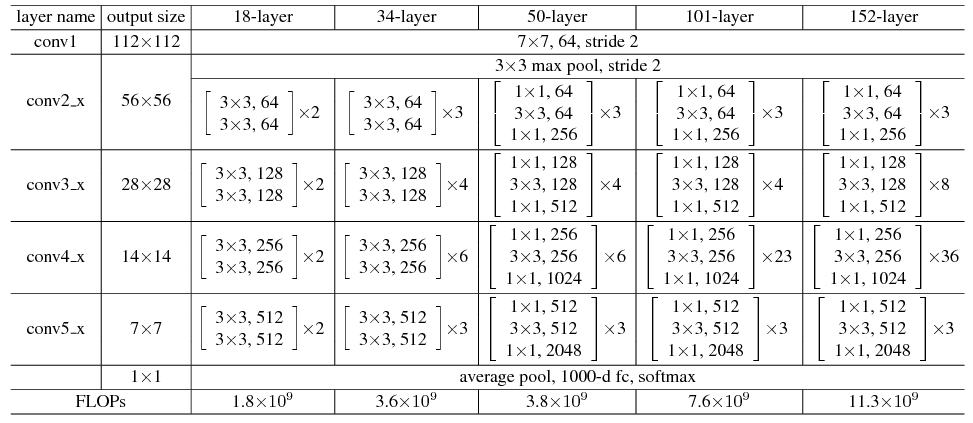

In [12]:
from IPython.display import Image
Image(filename='resnet_list.png') 

### 기본 블록 구성

In [3]:
# 기본 블록 구성하기
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

### ResNet 기본 블록 구성

기본은 ResNet34 이고, is_50 이 True 인 경우에만 ResNet50

In [4]:
# ResNet 기본 블록 구성하기
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

### ResNet 모델 구성

In [5]:
# ResNet 모델 구성하기
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### PlainNet 기본 블록 구성하기

ResNet 에서 short-cut connection 을 없앤 것을 PlainNet 으로 하고, 비교하기 위해서 정의

In [6]:
# PlainNet 기본 블록 구성하기
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

### PlainNet 모델 구성

In [7]:
# PlainNet 모델 구성하기
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 테스트 할 데이터셋 로드

In [8]:
# cats_vs_dogs 데이터셋 로드하기
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs 데이터셋이 tensorflow API 오류로 불러오지 못하는 경우가 있을 경우
# 로드하기 전에 이것을 추가해서 새 URL을 설정할 수 있습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True, # 데이터가 튜플로 반환, False는 dictionarty형태로 반환
    with_info=True, # 데이터의 정보를 같이 반환한다.
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\cats_vs_dogs\4.0.0.incompleteRTXH6T\cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


### 데이터 전처리 함수 정의

In [9]:
# 데이터 전처리하기(정규화 함수 만들기)
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 변수 선언

In [10]:
BATCH_SIZE = 32
EPOCH = 2

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet34 학습

In [14]:
# resnet_34 학습하기
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 112, 112, 64  256        ['conv2d_72[0][0]']              
 ormalization)                  )                                                         

 ormalization)                                                                                    
                                                                                                  
 add_35 (Add)                   (None, 28, 28, 128)  0           ['batch_normalization_81[0][0]', 
                                                                  'batch_normalization_79[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 28, 28, 128)  0           ['add_35[0][0]']                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_74[0][0]']          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 28, 28, 128)  512        ['conv2d_82[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_83[0][0]']          
                                                                                                  
 batch_normalization_92 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_40 (Add)                   (None, 14, 14, 256)  0           ['batch_normalization_92[0][0]', 
          

                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_93 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_103 (Conv2D)            (None, 7, 7, 512)    2359808     ['activation_93[0][0]']          
                                                                                                  
 conv2d_101 (Conv2D)            (None, 7, 7, 512)    131584      ['activation_92[0][0]']          
                                                                                                  
 batch_nor

In [ ]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### ResNet50 학습

In [15]:
# resnet_50 학습하기
resnet_50 = build_resnet(input_shape=(224, 224, 3),  
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 112, 112, 64  256        ['conv2d_108[0][0]']             
 Normalization)                 )                                                         

                                                                                                  
 conv2d_118 (Conv2D)            (None, 28, 28, 256)  16640       ['activation_107[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 28, 28, 256)  1024       ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_50 (Add)                   (None, 28, 28, 256)  0           ['batch_normalization_118[0][0]',
                                                                  'activation_105[0][0]']         
                                                                                                  
 activation_108 (Activation)    (None, 28, 28, 256)  0           ['add_50[0][0]']                 
          

 add_53 (Add)                   (None, 14, 14, 512)  0           ['batch_normalization_128[0][0]',
                                                                  'activation_114[0][0]']         
                                                                                                  
 activation_117 (Activation)    (None, 14, 14, 512)  0           ['add_53[0][0]']                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 14, 14, 128)  65664       ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_129 (Batch  (None, 14, 14, 128)  512        ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_139 (Batch  (None, 7, 7, 256)   1024        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_127 (Activation)    (None, 7, 7, 256)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_140 (Conv2D)            (None, 7, 7, 256)    590080      ['activation_127[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 7, 7, 256)   1024        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
          

 activation_137 (Activation)    (None, 7, 7, 256)    0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_150 (Conv2D)            (None, 7, 7, 1024)   263168      ['activation_137[0][0]']         
                                                                                                  
 batch_normalization_150 (Batch  (None, 7, 7, 1024)  4096        ['conv2d_150[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_60 (Add)                   (None, 7, 7, 1024)   0           ['batch_normalization_150[0][0]',
                                                                  'activation_135[0][0]']         
                                                                                                  
 activatio

                                                                                                  
 add_63 (Add)                   (None, 4, 4, 2048)   0           ['batch_normalization_160[0][0]',
                                                                  'activation_144[0][0]']         
                                                                                                  
 activation_147 (Activation)    (None, 4, 4, 2048)   0           ['add_63[0][0]']                 
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 2048)        0           ['activation_147[0][0]']         
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_3 (Dense)                (None, 1)            2049        ['global_average_pooling2d_3[0][0
          

In [ ]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### PlainNet34 학습

In [16]:
# plain_34 학습하기
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_161 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_161 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_148 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_162 (Conv2D)         (None, 56, 56, 64)        369

                                                                 
 activation_164 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_178 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_178 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_165 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_179 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_179 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activatio

In [ ]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### PlainNet50 학습

In [17]:
# plain_50 학습하기
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_194 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_194 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_181 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_195 (Conv2D)         (None, 56, 56, 64)        416

                                                                 
 activation_197 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_211 (Conv2D)         (None, 28, 28, 128)       147584    
                                                                 
 batch_normalization_211 (Ba  (None, 28, 28, 128)      512       
 tchNormalization)                                               
                                                                 
 activation_198 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_212 (Conv2D)         (None, 28, 28, 512)       66048     
                                                                 
 batch_normalization_212 (Ba  (None, 28, 28, 512)      2048      
 tchNormalization)                                               
                                                                 
 activatio

 tchNormalization)                                               
                                                                 
 activation_215 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_229 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_229 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_216 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_230 (Conv2D)         (None, 14, 14, 1024)      263168    
                                                                 
 batch_normalization_230 (Ba  (None, 14, 14, 1024)     4096      
 tchNormalization)                                               
          

In [ ]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 시각화하여 결과 비교

In [ ]:
%matplotlib Notebook inline

In [ ]:
# 시각화하여 결과 비교하기
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['loss'], 'g', linestyle='dashed')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['val_accuracy'], 'g', linestyle='dashed')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()